# Training

In [1]:
# !git clone https://github.com/adhiiisetiawan/nbr-time_aware_item_weighting
# %cd nbr-time_aware_item_weighting/
!pip install -r ../requirements.txt --quiet

DEPRECATION: celery 4.4.1 has a non-standard dependency specifier pytz>dev. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of celery or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
# TODO: Set periode (per bulan, per 2 minggu, dll.) diisi dengan jumlah detik dalam satu periode
# contoh: "periode = 3600 * 24 * 30" untuk per bulan, "periode = 3600 * 24 * 7 * 2" untuk per 2 minggu

periode = "3600 * 24 * 7 * 12"

lst = []
with open('../nbr/common/constants.py', 'r') as f:
    lst = f.readlines()

with open('../nbr/common/constants.py', 'w') as f:
    lst[0] = f"TIME_SCALAR = {periode}\n"
    f.seek(0)
    f.writelines(lst)    

In [3]:
import wandb

wandb.login()
wandb.init(project='nbr-tafeng', id='12w')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: fadliaulawi. Use `wandb login --relogin` to force relogin


In [4]:
import sys
sys.path.append("..")
from nbr.preparation import Preprocess, save_split, Corpus
from nbr.trainer import NBRTrainer
from nbr.model import NBRKNN, RepurchaseModule
from tqdm import tqdm
import torch
import random
import numpy as np
import optuna
import warnings

warnings.filterwarnings("ignore")

In [5]:
seed = 10
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [7]:
# TODO: Set apakah data perlu mem filter user dan item yang data transaksinya cukup sedikit
# Jika iya, min_user adalah minimal jumlah transaksi tiap user
# dan min_item minimal jumlah transaksi tiap item

filter = True
min_user = 5
min_item = 10

corpus_path = "data/"
dataset_name = "ta_feng"

preprocessor = Preprocess(corpus_path, dataset_name)
preprocessor.load_data(min_user, min_item, filt=filter)
save_split(corpus_path, dataset_name, preprocessor)

Before preprocessing: #users = 32266, #items = 23812, #clicks = 817741 (#illegal records = 0)
After preprocessing: #users = 7358, #items = 11202, #clicks = 368951
Saving dataset in data//data_ta_feng/...


In [8]:
corpus = Corpus(corpus_path, dataset_name)
corpus.load_data()

In [9]:
# Cek transaksi user 0
len(corpus.book[0]), corpus.book[0]

(92,
  <nbr.preparation.corpus.Click at 0x261e93fa200>])

In [10]:
trainer = NBRTrainer(
    corpus=corpus,
    max_epochs=20,
    topk=10,
    early_stop_num=100
)

train dataset preparing...


100%|██████████| 7358/7358 [00:22<00:00, 329.53it/s]


dev dataset preparing...


100%|██████████| 7357/7357 [00:03<00:00, 2347.84it/s]


test dataset preparing...


100%|██████████| 7357/7357 [00:04<00:00, 1834.49it/s]


In [11]:
slrc_best_params = {'batch_size': 256, 'lr': 0.00011201144001505824, 'l2_reg_coef': 0.00011498224071460201}

params = {
    "model": RepurchaseModule(
        item_num=corpus.n_items,
        avg_repeat_interval=corpus.total_avg_interval
    ),
    "batch_size": slrc_best_params["batch_size"],
    "lr": slrc_best_params["lr"],
    "l2_reg_coef": slrc_best_params["l2_reg_coef"]
}

trainer.init_hyperparams(**params)

Epoch 1:


Batch loss = 0.676187: 100%|██████████| 1112/1112 [00:54<00:00, 20.44it/s]


Evaluation (dev):



100%|██████████| 7357/7357 [04:20<00:00, 28.23it/s]


Epoch 2:


Batch loss = 0.67597: 100%|██████████| 1112/1112 [00:42<00:00, 26.47it/s] 


Evaluation (dev):



100%|██████████| 7357/7357 [03:47<00:00, 32.31it/s]

Epoch 3:



Batch loss = 0.675749: 100%|██████████| 1112/1112 [00:30<00:00, 36.04it/s]


Evaluation (dev):



100%|██████████| 7357/7357 [03:48<00:00, 32.25it/s]

Epoch 4:



Batch loss = 0.675524: 100%|██████████| 1112/1112 [00:30<00:00, 36.00it/s]


Evaluation (dev):



100%|██████████| 7357/7357 [03:40<00:00, 33.30it/s]

Epoch 5:



Batch loss = 0.675296: 100%|██████████| 1112/1112 [00:31<00:00, 35.70it/s]


Evaluation (dev):



100%|██████████| 7357/7357 [04:08<00:00, 29.64it/s]

Epoch 6:



Batch loss = 0.675065: 100%|██████████| 1112/1112 [00:32<00:00, 34.27it/s]


Evaluation (dev):



100%|██████████| 7357/7357 [03:57<00:00, 30.94it/s]

Epoch 7:



Batch loss = 0.674831: 100%|██████████| 1112/1112 [00:35<00:00, 31.64it/s]


Evaluation (dev):



100%|██████████| 7357/7357 [04:00<00:00, 30.54it/s]

Epoch 8:



Batch loss = 0.674594: 100%|██████████| 1112/1112 [00:33<00:00, 33.69it/s]


Evaluation (dev):



100%|██████████| 7357/7357 [03:48<00:00, 32.13it/s]

Epoch 9:



Batch loss = 0.674354: 100%|██████████| 1112/1112 [00:32<00:00, 34.09it/s]


Evaluation (dev):



100%|██████████| 7357/7357 [03:40<00:00, 33.32it/s]

Epoch 10:



Batch loss = 0.674112: 100%|██████████| 1112/1112 [00:33<00:00, 33.44it/s]


Evaluation (dev):



100%|██████████| 7357/7357 [03:38<00:00, 33.68it/s]

Epoch 11:



Batch loss = 0.673866: 100%|██████████| 1112/1112 [00:31<00:00, 35.00it/s]


Evaluation (dev):



100%|██████████| 7357/7357 [03:42<00:00, 33.11it/s]

Epoch 12:



Batch loss = 0.673618: 100%|██████████| 1112/1112 [00:31<00:00, 35.20it/s]


Evaluation (dev):



100%|██████████| 7357/7357 [03:44<00:00, 32.74it/s]

Epoch 13:



Batch loss = 0.673367: 100%|██████████| 1112/1112 [00:31<00:00, 35.16it/s]


Evaluation (dev):



100%|██████████| 7357/7357 [03:57<00:00, 30.93it/s]

Epoch 14:



Batch loss = 0.673114: 100%|██████████| 1112/1112 [00:30<00:00, 36.18it/s]


Evaluation (dev):



100%|██████████| 7357/7357 [03:52<00:00, 31.66it/s]

Epoch 15:



Batch loss = 0.672859: 100%|██████████| 1112/1112 [00:37<00:00, 29.58it/s]


Evaluation (dev):



100%|██████████| 7357/7357 [04:13<00:00, 29.04it/s]

Epoch 16:



Batch loss = 0.672602: 100%|██████████| 1112/1112 [00:33<00:00, 33.11it/s]


Evaluation (dev):



100%|██████████| 7357/7357 [04:39<00:00, 26.32it/s]

Epoch 17:



Batch loss = 0.672344: 100%|██████████| 1112/1112 [00:53<00:00, 20.82it/s]


Evaluation (dev):



100%|██████████| 7357/7357 [03:57<00:00, 30.98it/s]

Epoch 18:



Batch loss = 0.672085: 100%|██████████| 1112/1112 [00:51<00:00, 21.52it/s]


Evaluation (dev):



100%|██████████| 7357/7357 [03:41<00:00, 33.17it/s]

Epoch 19:



Batch loss = 0.671825: 100%|██████████| 1112/1112 [00:35<00:00, 31.18it/s]


Evaluation (dev):



100%|██████████| 7357/7357 [04:01<00:00, 30.43it/s]

Epoch 20:



Batch loss = 0.671564: 100%|██████████| 1112/1112 [00:32<00:00, 34.40it/s]


Evaluation (dev):



100%|██████████| 7357/7357 [03:50<00:00, 31.88it/s]


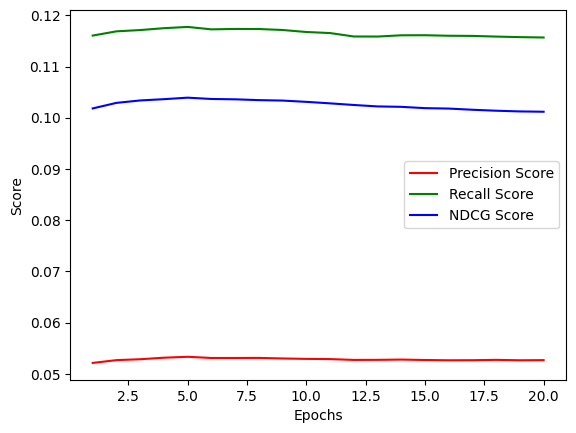

RepurchaseModule()

In [12]:
trainer.train()

In [ ]:
# wandb.finish()
#COPY REsULT

In [ ]:
trainer = NBRTrainer(
    corpus=corpus,
    max_epochs=100,
    topk=10,
    early_stop_num=3
)

slrc_best_params = {'batch_size': 256, 'lr': 0.00011201144001505824, 'l2_reg_coef': 0.00011498224071460201}

params = {
    "model": RepurchaseModule(
        item_num=corpus.n_items,
        avg_repeat_interval=corpus.total_avg_interval
    ),
    "batch_size": slrc_best_params["batch_size"],
    "lr": slrc_best_params["lr"],
    "l2_reg_coef": slrc_best_params["l2_reg_coef"]
}

trainer.init_hyperparams(**params)
with open("best_checkpoint-epm-12w.pth", "rb") as f:
    checkpoint = torch.load(f)
    trainer.model.load_state_dict(checkpoint)

train dataset preparing...


100%|██████████| 576/576 [00:00<00:00, 1699.15it/s]


dev dataset preparing...


100%|██████████| 539/539 [00:05<00:00, 104.36it/s]


test dataset preparing...


100%|██████████| 539/539 [00:05<00:00, 102.37it/s]


In [ ]:
# TODO: Set tanggal tertentu yang ingin diprediksi, DEFAULT nya adalah tanggal terakhir pembelian tiap item

date_to_predict = "2023-12-29"
# date_to_predict = None

test_user_emb, test_data = trainer.get_predictions(mode="test", timestamp=date_to_predict)

  0%|          | 0/539 [00:00<?, ?it/s]

100%|██████████| 539/539 [00:15<00:00, 35.12it/s]


In [ ]:
print('user_id:      ', test_data[0]['user_id'][0])
print('predict_time: ', test_data[0]['t'][0])
print(test_user_emb[0][:10])
print(test_data[0]['length'][:10])

user_id:       tensor(0, dtype=torch.int32)
predict_time:  tensor(234.7619)
[1.67944451e-02 1.35924605e-07 6.29842567e-05 3.83409246e-01
 7.86405594e-03 2.13189328e-04 2.26147846e-08 6.62043408e-02
 2.94508388e-04 7.24544811e-03]
tensor([11.,  4.,  4., 17., 11.,  3.,  3.,  6., 10.,  9.], dtype=torch.float64)


In [ ]:
8 weeks

1 2 3 4 5 6 7 8 9 10 11 12
x o x o x o x o x o  x  o  

1 2 3 4 5 6 7 8 9 10 11 12
x o x o x o

In [ ]:
trainer2 = NBRTrainer(
    corpus=corpus,
    max_epochs=None,
    topk=10,
    early_stop_num=None
)

In [29]:
x = [i for i in range(10, 201, 10)]
y = [i / 10 for i in range(1, 11)]
y = [0.9, 1]
scores = []

for j in y:
    sc = []
    for i in x:
        params2 = {
            "model": NBRKNN(
                item_num=corpus.n_items,
                user_num=corpus.n_users,
                nearest_neighbors_num=i,
                alpha=j,
                user_emb=test_user_emb
            )
        }

        trainer2.init_hyperparams(**params2)
        metrics = trainer2.evaluate(mode="test")
        score = metrics['ndcg']
        sc.append(score)
    scores.append(sc)


100%|██████████| 539/539 [00:04<00:00, 126.42it/s]


In [24]:
scores

[[0.26378016448409447,
  0.26378016448409447,
  0.26378016448409447,
  0.26378016448409447,
  0.26378016448409447,
  0.26378016448409447,
  0.26378016448409447,
  0.26378016448409447,
  0.26378016448409447,
  0.26378016448409447,
  0.26378016448409447,
  0.26378016448409447,
  0.26378016448409447,
  0.26378016448409447,
  0.26378016448409447,
  0.26378016448409447,
  0.26378016448409447,
  0.26378016448409447,
  0.26378016448409447,
  0.26378016448409447]]

In [ ]:
wandb.log({'Num Neighbors & Alpha': wandb.plots.HeatMap(x, y, scores, show_text=True)})

wandb: WARNING wandb.plots.* functions are deprecated and will be removed in a future release. Please use wandb.plot.* instead.
wandb: Visualizing heatmap.


In [28]:
def objective(trial):
    params = {
        "model": NBRKNN(
            item_num=corpus.n_items,
            user_num=corpus.n_users,
            nearest_neighbors_num=trial.suggest_int("nearest_neighbors_num", low=0, high=100, step=10),
            alpha=trial.suggest_float("alpha", 0.0, 1.0, step=0.1),
            user_emb=test_user_emb
        )
    }

    trainer2.init_hyperparams(**params)
    metrics = trainer2.evaluate(mode="test")
    score = metrics["ndcg"]
    return score

sampler = optuna.samplers.TPESampler(seed=seed)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)

In [25]:
trainer2 = NBRTrainer(
    corpus=corpus,
    max_epochs=None,
    topk=10,
    early_stop_num=None
)

params2 = {
    "model": NBRKNN(
        item_num=corpus.n_items,
        user_num=corpus.n_users,
        nearest_neighbors_num=10,
        alpha=1,
        user_emb=test_user_emb
    )
}

# params["model"].set_emb(test_user_emb)

trainer2.init_hyperparams(**params2)
metrics = trainer2.evaluate(mode="test")
metrics

train dataset preparing...


  8%|▊         | 45/576 [00:00<00:01, 424.55it/s]

100%|██████████| 576/576 [00:01<00:00, 493.02it/s]


dev dataset preparing...


100%|██████████| 539/539 [00:14<00:00, 37.45it/s] 


test dataset preparing...


100%|██████████| 539/539 [00:05<00:00, 97.19it/s] 


{'precision': 0.1287569573283859,
 'recall': 0.3413082099146733,
 'ndcg': 0.26378016448409447}

In [26]:
import pandas as pd

data = pd.read_csv('data/EPM.csv', index_col=None)
sorted_data = data.sort_values(['ship_to_id', 'trx_date']).reset_index(drop=True)

In [27]:
def inference(user, topk):
    n_items = corpus.n_items

    items_scores = trainer2.model.predict_for_user(user).view(-1, n_items)
    top_items = torch.topk(items_scores, k=topk, dim=1, sorted=True).indices
    top_score = [float(i) for i in items_scores[0]]

    print(sorted(data['ship_to_id'].unique())[user])
    print("Item  | Score")
    print('-------------')
    total = sum(items_scores[0])
    for i in top_items[0]:
        print("{:5} | {:<5} | {}%".format(sorted_data['item_code'].unique()[int(i)], round(top_score[i], 3), round(top_score[i] / float(total) * 100, 2)))
    print()

top_k = 10
user_id = 0

inference(user_id, top_k)

EPM_1096687
Item  | Score
-------------
MCDHP | 1.673 | 3.87%
MCGMB | 1.401 | 3.24%
MCGVB | 1.319 | 3.05%
CRTDV | 0.969 | 2.24%
BLCKI | 0.968 | 2.24%
BLCKS | 0.884 | 2.04%
TRLSC | 0.868 | 2.01%
CRTDC | 0.844 | 1.95%
TPODA | 0.844 | 1.95%
TALNF | 0.821 | 1.9%



# Load

In [1]:
# !git clone https://github.com/adhiiisetiawan/nbr-time_aware_item_weighting
# %cd nbr-time_aware_item_weighting/
!pip install -r ../requirements.txt --quiet

DEPRECATION: celery 4.4.1 has a non-standard dependency specifier pytz>dev. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of celery or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
import sys
sys.path.append("..")
from nbr.preparation import Preprocess, save_split, Corpus
from nbr.trainer import NBRTrainer
from nbr.model import NBRKNN, RepurchaseModule
import torch
import random
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [3]:
seed = 10
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [4]:
corpus_path = "data/"
dataset_name = "EPM-prep"

preprocessor = Preprocess(corpus_path, dataset_name)
preprocessor.load_data(0, 0, filt=False)
save_split(corpus_path, dataset_name, preprocessor)

corpus = Corpus(corpus_path, dataset_name)
corpus.load_data()

Before preprocessing: #users = 576, #items = 1477, #clicks = 518655 (#illegal records = 0)
After preprocessing: #users = 576, #items = 1477, #clicks = 518655
Saving dataset in data//data_EPM-prep/...


In [5]:
trainer = NBRTrainer(
    corpus=corpus,
    max_epochs=100,
    topk=10,
    early_stop_num=3
)

slrc_best_params = {'batch_size': 256, 'lr': 0.00011201144001505824, 'l2_reg_coef': 0.00011498224071460201}

params = {
    "model": RepurchaseModule(
        item_num=corpus.n_items,
        avg_repeat_interval=corpus.total_avg_interval
    ),
    "batch_size": slrc_best_params["batch_size"],
    "lr": slrc_best_params["lr"],
    "l2_reg_coef": slrc_best_params["l2_reg_coef"]
}

trainer.init_hyperparams(**params)
with open("best_checkpoint-epm-12w.pth", "rb") as f:
    checkpoint = torch.load(f)
    trainer.model.load_state_dict(checkpoint)

train dataset preparing...


100%|██████████| 576/576 [00:00<00:00, 1043.45it/s]


dev dataset preparing...


100%|██████████| 539/539 [00:09<00:00, 59.05it/s] 


test dataset preparing...


100%|██████████| 539/539 [00:09<00:00, 54.80it/s] 


In [6]:
# TODO: Set tanggal tertentu yang ingin diprediksi
# DEFAULT nya adalah tanggal terakhir pembelian tiap item

# date_to_predict = "2023-12-29"
date_to_predict = None

# dev_user_emb, dev_data = trainer.get_predictions(mode="dev", timestamp=date_to_predict)
test_user_emb, test_data = trainer.get_predictions(mode="test", timestamp=date_to_predict)

100%|██████████| 539/539 [00:19<00:00, 27.01it/s]


In [14]:
trainer2 = NBRTrainer(
    corpus=corpus,
    max_epochs=None,
    topk=10,
    early_stop_num=None
)

# HARD CODED based on training process
best_study = {
    'nearest_neighbors_num': 70,
    'alpha': 1.0
}

params2 = {
    "model": NBRKNN(
        item_num=corpus.n_items,
        user_num=corpus.n_users,
        nearest_neighbors_num=best_study["nearest_neighbors_num"],
        alpha=best_study["alpha"],
        user_emb=test_user_emb
    )
}
params2["model"].set_emb(test_user_emb)

trainer2.init_hyperparams(**params2)
trainer2.evaluate(mode='test')

train dataset preparing...


  0%|          | 0/576 [00:00<?, ?it/s]

100%|██████████| 576/576 [00:00<00:00, 1285.54it/s]


dev dataset preparing...


100%|██████████| 539/539 [00:07<00:00, 71.26it/s] 


test dataset preparing...


100%|██████████| 539/539 [00:05<00:00, 102.85it/s]


{'precision': 0.13562152133580704,
 'recall': 0.3620803892837899,
 'ndcg': 0.2842255078413231}

In [9]:
import pandas as pd

data = pd.read_csv('data/EPM.csv')

In [10]:
def inference(user, topk):
    n_items = corpus.n_items

    items_scores = trainer.model.predict_for_user(user).view(-1, n_items)
    top_items = torch.topk(items_scores, k=topk, dim=1, sorted=True).indices
    top_score = [float(i) for i in items_scores[0]]

    print(sorted(data['customer_name'].unique())[user])
    print("Item  | Score")
    print('-------------')
    for i in top_items[0]:
        print("{:5} | {:<5}".format(sorted(data['item_code'].unique())[int(i)], round(top_score[i], 3)))
    print()

top_k = 5
user_id = 1

inference(433, 5)
# for i in [1, 12, 123]:
#     inference(i, top_k)

JK1-APOTEK JATI FARMA_GROUP_NA
Item  | Score
-------------
10224 | 0.0  
10225 | 0.0  
00869 | 0.0  
00868 | 0.0  
10223 | 0.0  



In [11]:
trainer.evaluate_fully(mode='test', topk=[1, 3, 5, 10, 50])

100%|██████████| 453/453 [00:03<00:00, 142.01it/s]


{'precision': {'@1': 0.22075055187637968,
  '@3': 0.17218543046357615,
  '@5': 0.15275938189845475,
  '@10': 0.11567328918322298,
  '@50': 0.05479028697571744},
 'recall': {'@1': 0.10169930093392149,
  '@3': 0.20035191720972317,
  '@5': 0.2714082047816094,
  '@10': 0.3663527527189077,
  '@50': 0.6636623068713118},
 'ndcg': {'@1': 0.11970787570639996,
  '@3': 0.1941751650231531,
  '@5': 0.23378956977790813,
  '@10': 0.2778382944080823,
  '@50': 0.37954528318269803}}